# Lending Tree Loan Status: SMOTE
## Classification - Logistic Regression HPO GPU

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/RAPIDS/

/content/drive/MyDrive/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,867 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.lau

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
!pip install plotly
import os
import random
import time
from contextlib import contextmanager
import numpy as np
import cupy 
import cudf
import cuml
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask, dask_cudf
from dask.diagnostics import ProgressBar
import dask_optuna
import urllib.request
from cuml.preprocessing import train_test_split
from cuml.linear_model import LogisticRegression
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import joblib
from joblib import parallel_backend
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import warnings
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi=96

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print('\n')
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 48.7 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 209 kB 57.7 MB/s 
     |████████████████████████████████| 150 kB 50.5 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 55.6 MB/s 
     |████████████████████████████████| 146 kB 41.7 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=fbdc3445344ec565ab93d09a18fa426f1a72f81ab725ba4855e5c83799c3d77f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://172.28.0.2:8081/status,
Dashboard: http://172.28.0.2:8081/status,Workers: 1
Total threads: 1,Total memory: 25.46 GiB
Status: running,Using processes: True
Comm: tcp://172.28.0.2:45651,Workers: 1
Dashboard: http://172.28.0.2:8081/status,Total threads: 1
Started: Just now,Total memory: 25.46 GiB
Comm: tcp://172.28.0.2:45657,Total threads: 1
Dashboard: http://172.28.0.2:40543/status,Memory: 25.46 GiB
Nanny: tcp://172.28.0.2:39637,


In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set seed 
seed_value = 42
os.environ['Linear_GPU'] = str(seed_value)
cupy.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('trainDF_SMOTE.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF = cudf.read_csv('testDF_SMOTE.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [ ]:
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

## Weighted F1 

### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lr_optuna_SMOTE_1000_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l2', tol=1e-4, 
                   C=1, max_iter=10000, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: F1 score of the fitted model
    """    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')
    
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                               C=C, max_iter=max_iter, 
                               linesearch_max_iter=linesearch_max_iter, 
                               l1_ratio=l1_ratio, solver=solver, 
                               fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = f1_score(y_test.to_numpy(), y_pred.to_numpy(), average='weighted')
    
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 9.429476309999927
- Trial weighted F1: 0.8147946302801139
######################################################
Score with default parameters :  0.8147946302801139


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Logistic_Optuna_SMOTE_1000_GPU_F1weighted.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)     
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_SMOTE_1000_GPU_F1weighted.pkl'): 
        study = joblib.load('Logistic_Optuna_SMOTE_1000_GPU_F1weighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-07-03 00:02:53.567255
- Trial time: 1.6053227390000302
- Trial weighted F1: 0.9458775898596125
######################################################
- Trial time: 0.2872083019999536
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.2812994149999213
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 1.5038329589999648
- Trial weighted F1: 0.9456850364284123
######################################################
- Trial time: 0.2778897580001285
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.27961980100008077
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.29076430700001765
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.28171163699994395
- Trial weighted F1:

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=False)
trials_df.to_csv('Logistic_Optuna_SMOTE_1000_GPU_weightedF1.csv', index=False)
print(trials_df) 

     iteration  f1_weighted             datetime_start  \
959        959     0.972439 2022-07-03 00:43:10.390023   
814        814     0.969054 2022-07-03 00:35:55.543949   
445        445     0.969030 2022-07-03 00:18:40.336153   
686        686     0.968703 2022-07-03 00:29:35.061517   
111        111     0.968684 2022-07-03 00:06:13.391763   
..         ...          ...                        ...   
638        638     0.814795 2022-07-03 00:27:04.815365   
865        865     0.814795 2022-07-03 00:38:51.879343   
77          77     0.814795 2022-07-03 00:05:10.197625   
266        266     0.814795 2022-07-03 00:11:58.788079   
796        796     0.814795 2022-07-03 00:34:44.016613   

             datetime_complete               duration    C  l1_ratio  \
959 2022-07-03 00:43:14.687646 0 days 00:00:04.297623  6.4  0.040570   
814 2022-07-03 00:35:58.932500 0 days 00:00:03.388551  9.1  0.518851   
445 2022-07-03 00:18:44.274083 0 days 00:00:03.937930  9.1  0.966094   
686 2022-07-03 

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

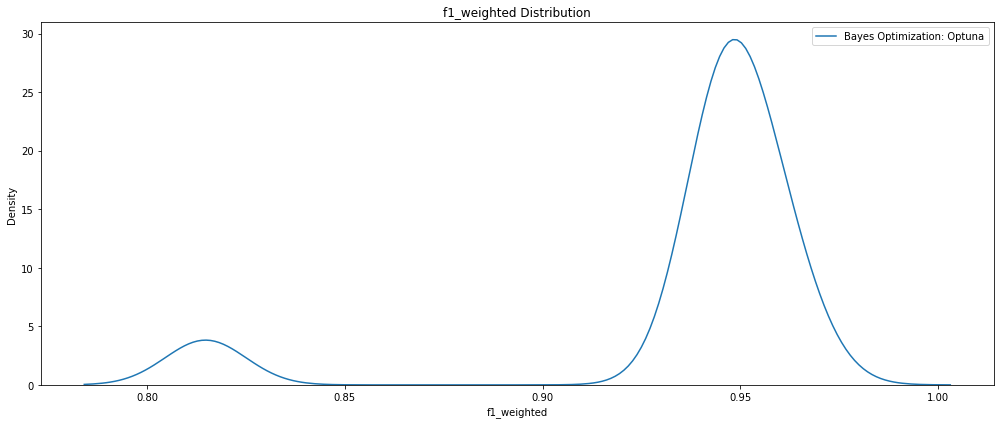

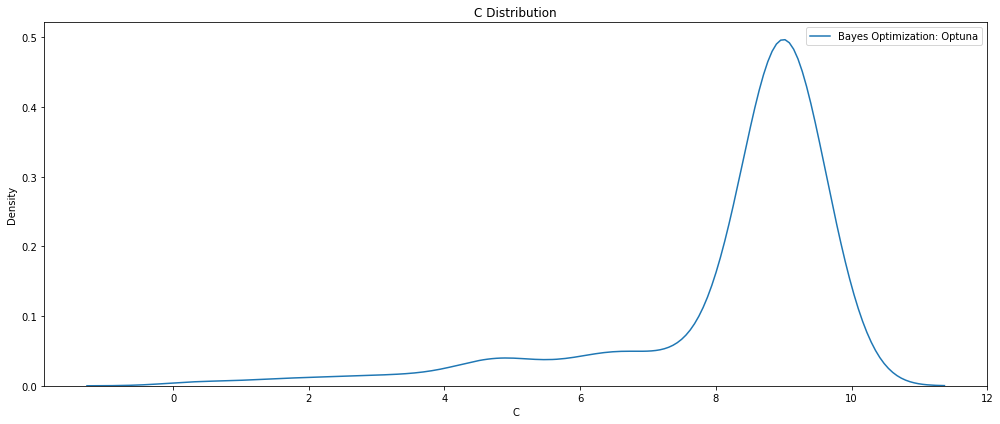

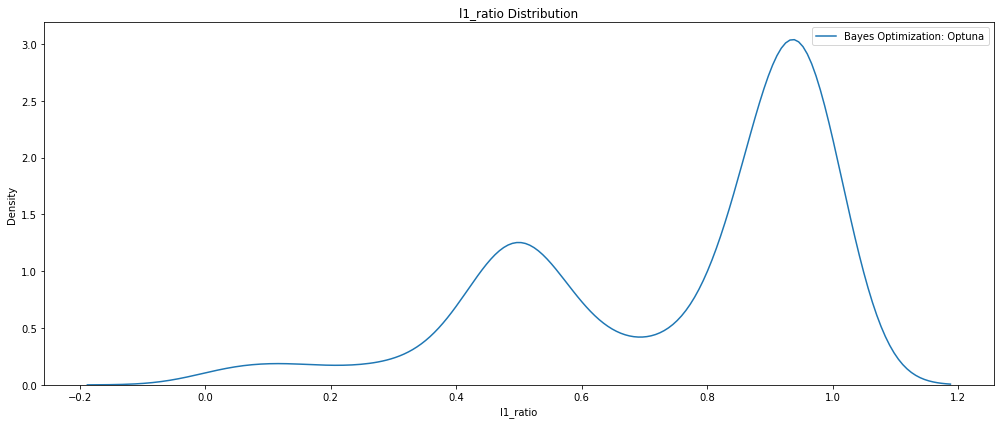

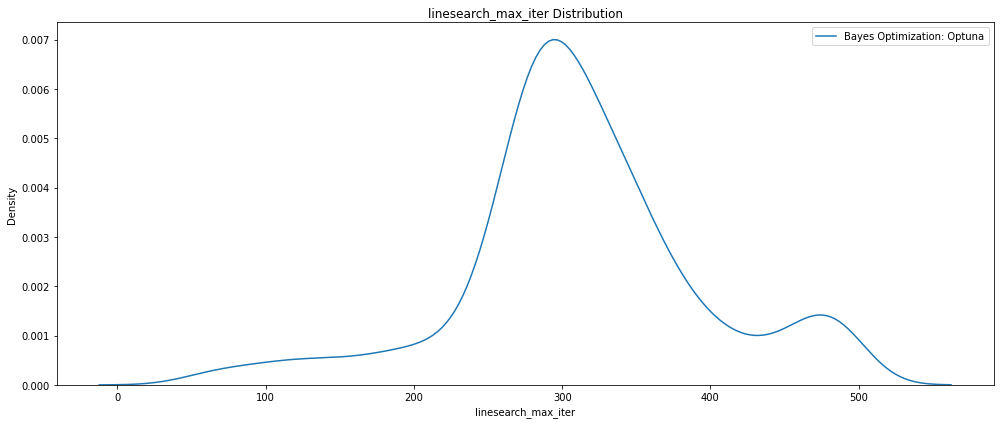

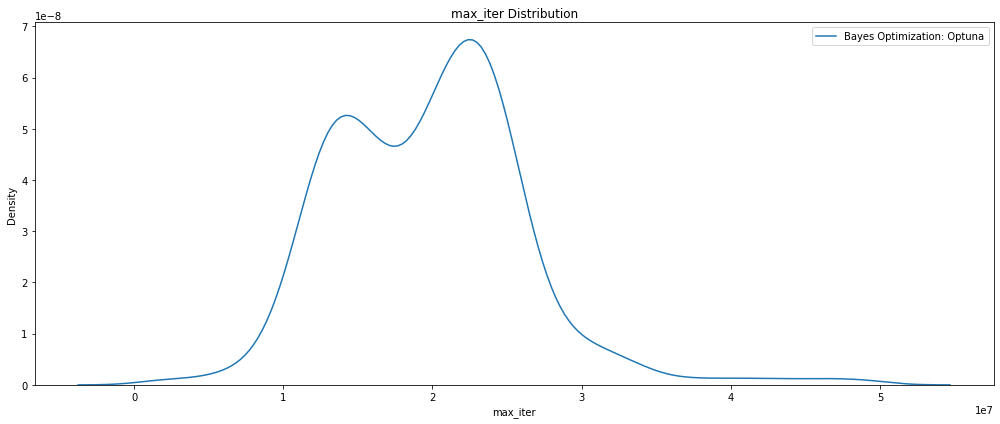

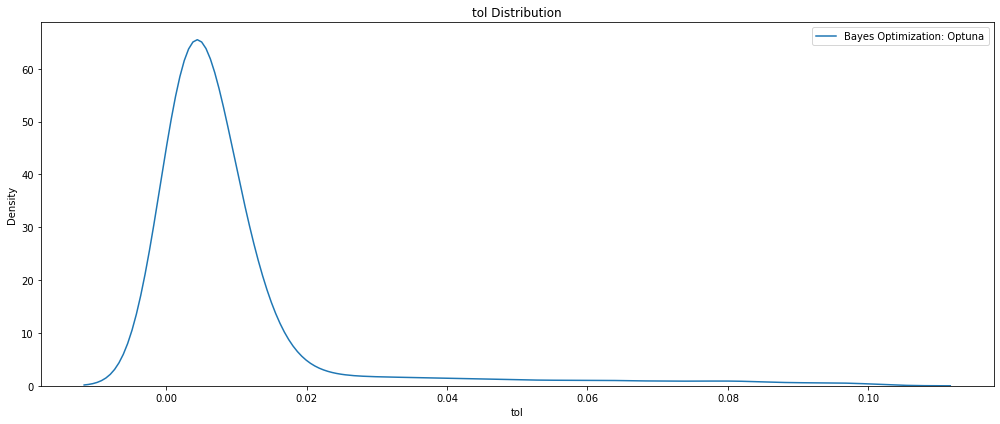

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 6.4,
 'l1_ratio': 0.04056987244091537,
 'linesearch_max_iter': 313,
 'max_iter': 29074801,
 'penalty': 'l1',
 'tol': 6.69075865843533e-05}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_SMOTE_trials1000_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_SMOTE_trials1000_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Logistic HPO SMOTE 1000 trials GPU F1 weighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(),
                                         y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO SMOTE 1000 trials GPU F1 weighted


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    377848
           1       0.80      0.77      0.78     54625

    accuracy                           0.95    432473
   macro avg       0.88      0.87      0.88    432473
weighted avg       0.95      0.95      0.95    432473



Confusion matrix:
[[367170  10678]
 [ 12566  42059]]


Accuracy score : 0.946
Precision score : 0.798
Recall score : 0.770
F1 score : 0.783


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 1000 GPU F1 weighted trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                       y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 1000 GPU F1 weighted trials optimization scores 0.87085 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     959
f1_weighted                              0.972439
datetime_start         2022-07-03 00:43:10.390023
datetime_complete      2022-07-03 00:43:14.687646
duration                   0 days 00:00:04.297623
C                                             6.4
l1_ratio                                  0.04057
linesearch_max_iter                           313
max_iter                                 29074801
penalty                                        l1
tol                                      0.000067
state                                    COMPLETE
Name: 959, dtype: object


## ROC Weighted

### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lr_optuna_SMOTE_1000_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=1e6, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC score of the fitted model
    """    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')
    
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                               C=C, max_iter=max_iter, 
                               linesearch_max_iter=linesearch_max_iter, 
                               l1_ratio=l1_ratio, solver=solver, 
                               fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy(), 
                          average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.8374529029997575
- Trial weighted ROC: 0.8709956255459377
######################################################
Score with default parameters :  0.8709956255459377


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)     
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.pkl'): 
        study = joblib.load('Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted', study.best_value)

Start Time           2022-07-03 00:55:25.016267
- Trial time: 0.25255386699973315
- Trial weighted ROC: 0.5
######################################################
- Trial time: 1.453043945999525
- Trial weighted ROC: 0.8709769094126065
######################################################
- Trial time: 1.5354868469994472
- Trial weighted ROC: 0.8708533543472762
######################################################
- Trial time: 0.2605064150002363
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.288072524999734
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.2678535439999905
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.25217915099983657
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.2629623740003808
- Trial weighted ROC: 0.5
######################################################
- Trial ti

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=False)
trials_df.to_csv('Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.csv', index=False)
print(trials_df) 

     iteration  roc_weighted             datetime_start  \
568        568      0.919314 2022-07-03 01:14:39.251349   
575        575      0.919179 2022-07-03 01:14:59.486338   
392        392      0.918956 2022-07-03 01:07:00.713694   
540        540      0.918668 2022-07-03 01:13:08.783495   
922        922      0.918410 2022-07-03 01:30:26.414896   
..         ...           ...                        ...   
867        867      0.500000 2022-07-03 01:28:02.532683   
170        170      0.500000 2022-07-03 00:59:49.053291   
296        296      0.500000 2022-07-03 01:03:38.944948   
685        685      0.500000 2022-07-03 01:20:01.411642   
0            0      0.500000 2022-07-03 00:55:25.018121   

             datetime_complete               duration     C  l1_ratio  \
568 2022-07-03 01:14:43.607733 0 days 00:00:04.356384   9.5  0.346366   
575 2022-07-03 01:15:20.540681 0 days 00:00:21.054343   9.0  0.244626   
392 2022-07-03 01:07:03.617874 0 days 00:00:02.904180   9.1  0.398020   

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

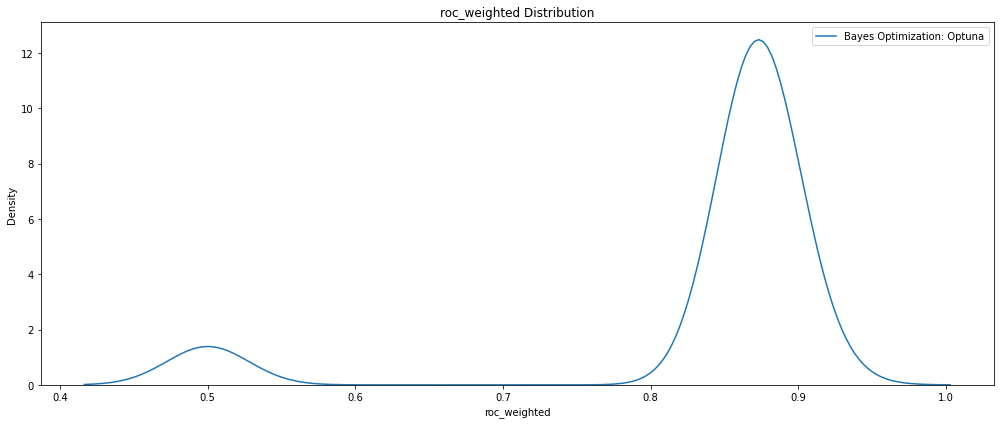

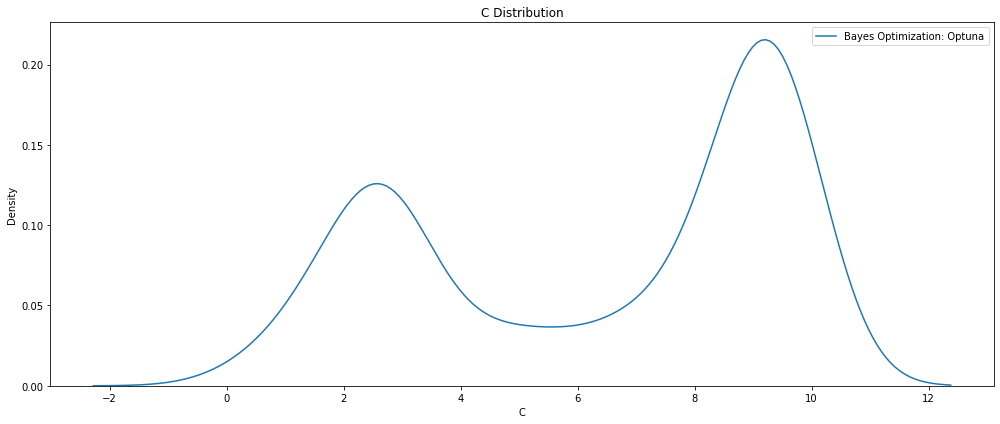

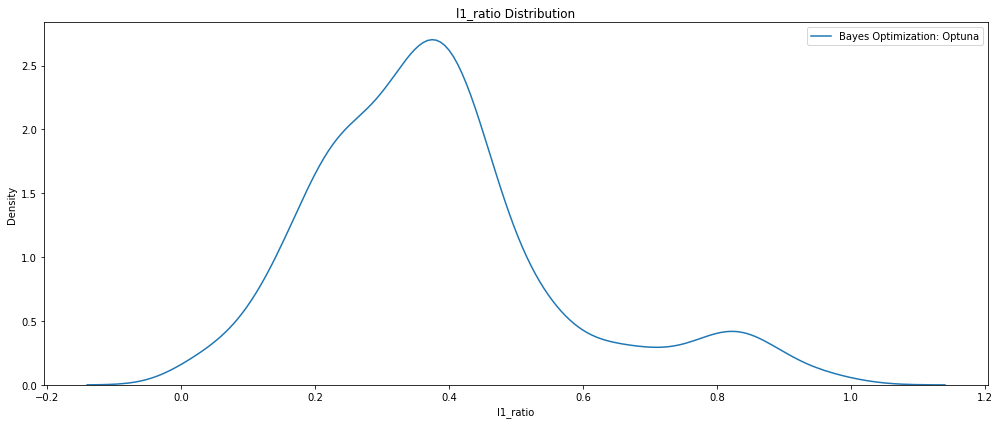

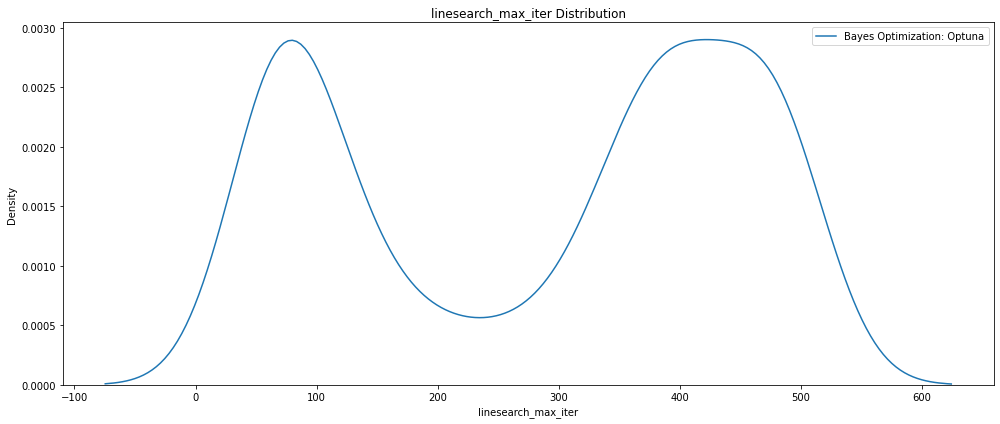

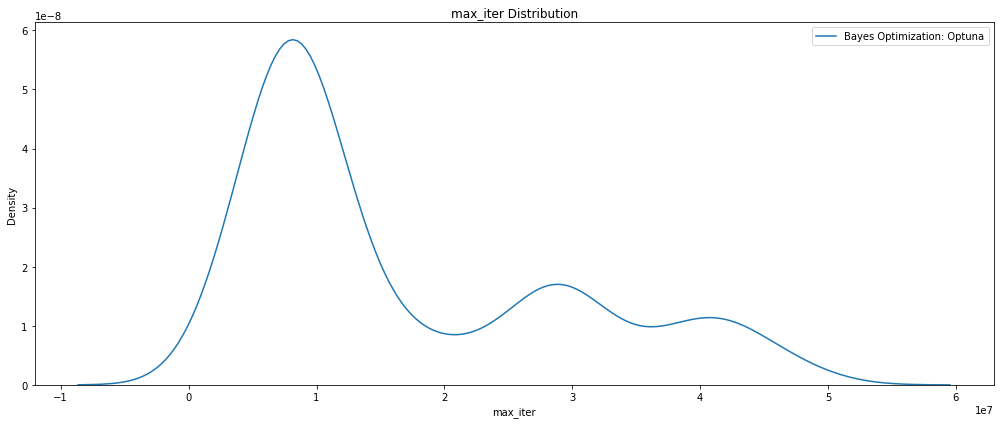

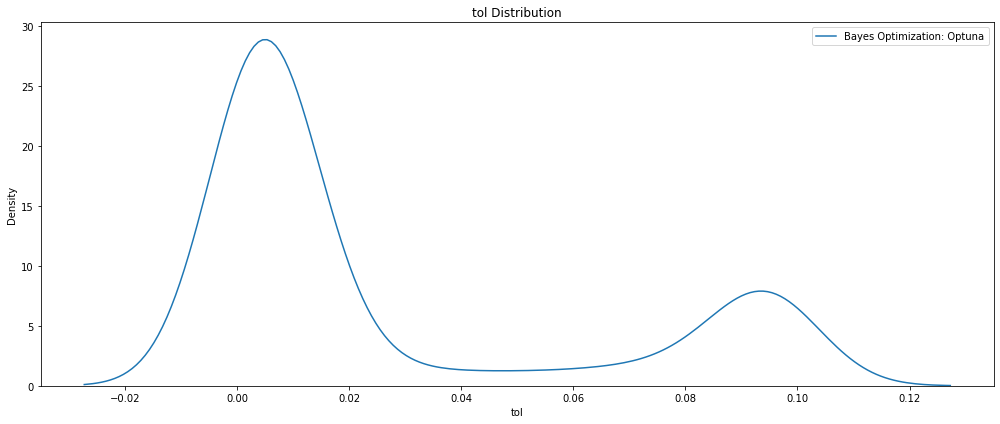

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 9.5,
 'l1_ratio': 0.3463658367799553,
 'linesearch_max_iter': 498,
 'max_iter': 7486185,
 'penalty': 'l1',
 'tol': 0.006343387173651861}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

[W] [01:45:06.558448] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


In [ ]:
print('\nModel Metrics for Logistic HPO SMOTE 1000 trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO SMOTE 1000 trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    377848
           1       0.80      0.77      0.78     54625

    accuracy                           0.95    432473
   macro avg       0.88      0.87      0.88    432473
weighted avg       0.95      0.95      0.95    432473



Confusion matrix:
[[367191  10657]
 [ 12572  42053]]


Accuracy score : 0.946
Precision score : 0.798
Recall score : 0.770
F1 score : 0.784


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 1000 GPU ROCweighted trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                       y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 1000 GPU ROCweighted trials optimization scores 0.87082 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     568
roc_weighted                             0.919314
datetime_start         2022-07-03 01:14:39.251349
datetime_complete      2022-07-03 01:14:43.607733
duration                   0 days 00:00:04.356384
C                                             9.5
l1_ratio                                 0.346366
linesearch_max_iter                           498
max_iter                                  7486185
penalty                                        l1
tol                                      0.006343
state                                    COMPLETE
Name: 568, dtype: object


## Recall

### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lr_optuna_SMOTE_1000_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=10000, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall of the fitted model
    """    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')
    
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                               C=C, max_iter=max_iter, 
                               linesearch_max_iter=linesearch_max_iter, 
                               l1_ratio=l1_ratio, solver=solver, 
                               fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = recall_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial recall score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 2.274571097000262
- Trial recall score: 0.7705080091533181
######################################################
Score with default parameters :  0.7705080091533181


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Logistic_Optuna_SMOTE_1000_GPU_Recall.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)     
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_SMOTE_1000_GPU_Recall.pkl'): 
        study = joblib.load('Logistic_Optuna_SMOTE_1000_GPU_Recall.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall', study.best_value)

Start Time           2022-07-03 01:45:48.034376
- Trial time: 0.2834903689999919
- Trial recall score: 0.0
######################################################
- Trial time: 0.29059318600047845
- Trial recall score: 0.0
######################################################
- Trial time: 1.6012453469993488
- Trial recall score: 0.7697391304347826
######################################################
- Trial time: 0.2826350260002073
- Trial recall score: 0.0
######################################################
- Trial time: 0.27532598300058453
- Trial recall score: 0.0
######################################################
- Trial time: 1.5210892329996568
- Trial recall score: 0.7702517162471396
######################################################
- Trial time: 0.2835198359998685
- Trial recall score: 0.0
######################################################
- Trial time: 0.27904034099992714
- Trial recall score: 0.0
######################################################
- Trial

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=False)
trials_df.to_csv('Logistic_Optuna_SMOTE_1000_GPU_Recall.csv', index=False)
print(trials_df) 

     iteration    recall             datetime_start  \
618        618  0.875551 2022-07-03 02:03:24.965987   
949        949  0.867039 2022-07-03 02:16:12.942109   
704        704  0.865794 2022-07-03 02:06:24.900699   
995        995  0.863799 2022-07-03 02:18:10.334981   
986        986  0.843661 2022-07-03 02:17:47.732697   
..         ...       ...                        ...   
597        597  0.000000 2022-07-03 02:02:45.665819   
605        605  0.000000 2022-07-03 02:03:00.115396   
619        619  0.000000 2022-07-03 02:03:30.370105   
627        627  0.000000 2022-07-03 02:03:48.063845   
0            0  0.000000 2022-07-03 01:45:48.036877   

             datetime_complete               duration    C  l1_ratio  \
618 2022-07-03 02:03:30.369599 0 days 00:00:05.403612  0.1  0.612537   
949 2022-07-03 02:16:17.351540 0 days 00:00:04.409431  0.9  0.546201   
704 2022-07-03 02:06:39.198645 0 days 00:00:14.297946  0.1  0.844183   
995 2022-07-03 02:18:13.157605 0 days 00:00:02.8226

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

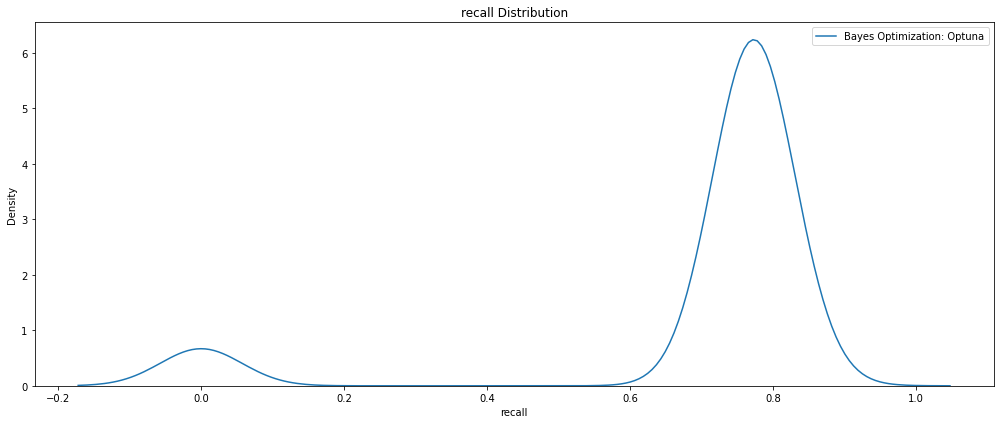

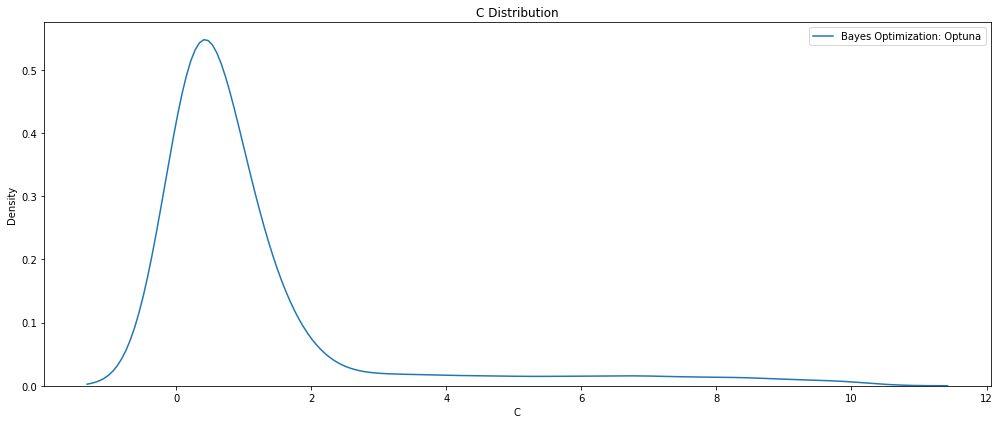

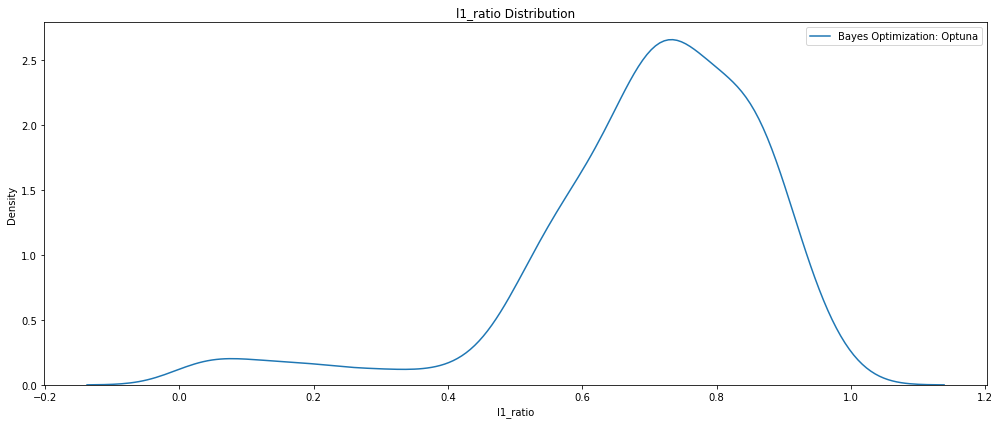

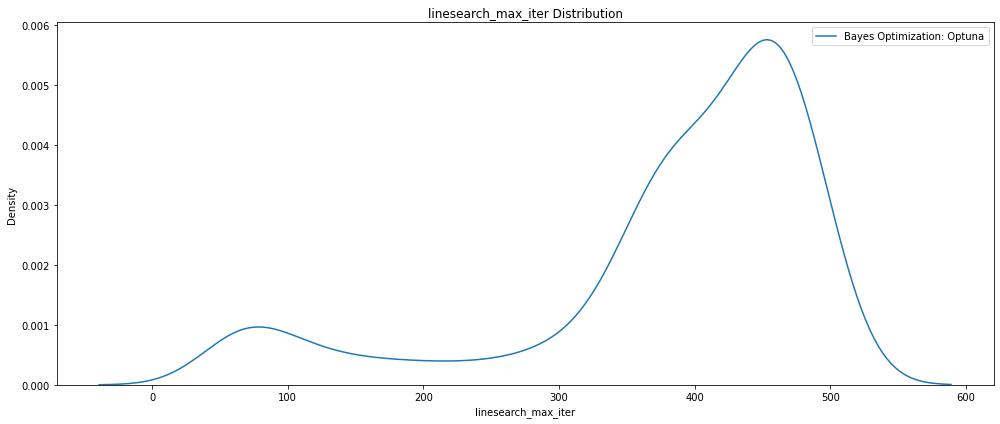

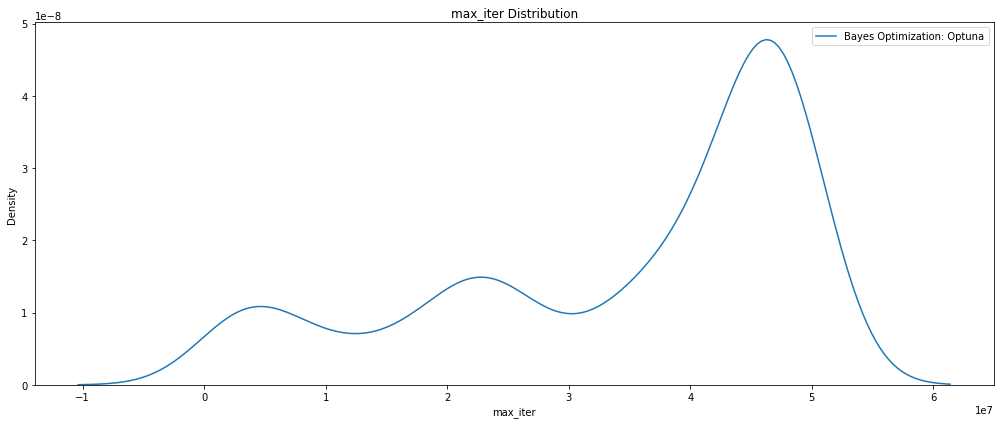

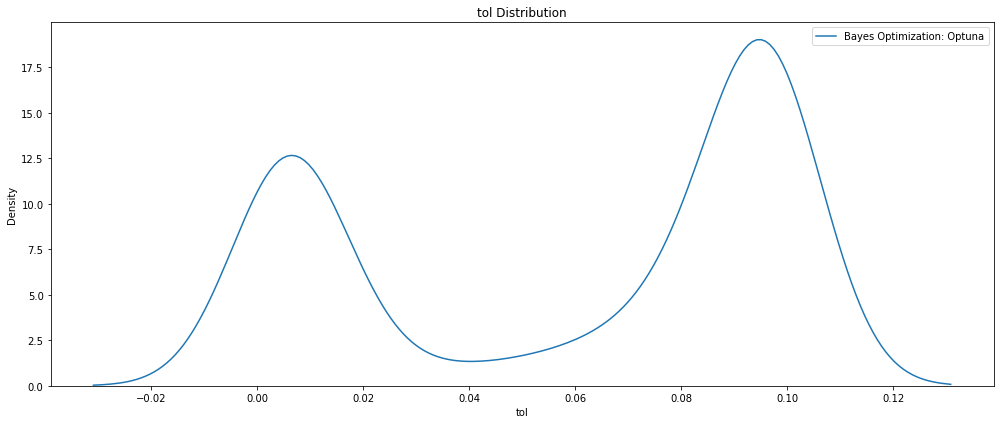

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 0.1,
 'l1_ratio': 0.6125365515167951,
 'linesearch_max_iter': 486,
 'max_iter': 49832519,
 'penalty': 'l1',
 'tol': 0.010009900223863707}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_SMOTE_trials1000_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_SMOTE_trials1000_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Logistic HPO SMOTE 1000 trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO SMOTE 1000 trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    377848
           1       0.76      0.78      0.77     54625

    accuracy                           0.94    432473
   macro avg       0.87      0.87      0.87    432473
weighted avg       0.94      0.94      0.94    432473



Confusion matrix:
[[364749  13099]
 [ 12243  42382]]


Accuracy score : 0.941
Precision score : 0.764
Recall score : 0.776
F1 score : 0.770


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 1000 GPU Recall trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                  y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 1000 GPU Recall trials optimization scores 0.87060 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     618
recall                                   0.875551
datetime_start         2022-07-03 02:03:24.965987
datetime_complete      2022-07-03 02:03:30.369599
duration                   0 days 00:00:05.403612
C                                             0.1
l1_ratio                                 0.612537
linesearch_max_iter                           486
max_iter                                 49832519
penalty                                        l1
tol                                       0.01001
state                                    COMPLETE
Name: 618, dtype: object


## Precision

### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lr_optuna_SMOTE_1000_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, penalty='l1', tol=1e-4, 
                   C=1, max_iter=1e6, linesearch_max_iter=50, 
                   l1_ratio=None, solver='qn', 
                   fit_intercept=True, verbose=0):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    """    
    
    # Set up features and target
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32') 
    X_train = X_train.astype('float32')
    
    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = LogisticRegression(penalty=penalty, tol=tol, 
                               C=C, max_iter=max_iter, 
                               linesearch_max_iter=linesearch_max_iter, 
                               l1_ratio=l1_ratio, solver=solver, 
                               fit_intercept=fit_intercept, verbose=verbose) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    score = precision_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision score:', score)
    print('######################################################')
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.7683189809995383
- Trial Precision score: 0.7961750907990315
######################################################
Score with default parameters :  0.7961750907990315


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Logistic_Optuna_SMOTE_1000_GPU_Precision.pkl')
    
    # Search parameters
    penalty = trial.suggest_categorical('penalty', ['none', 'l1', 'l2'])   
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    C = trial.suggest_float('C', 0.1, 10, step=0.1)
    max_iter = trial.suggest_int('max_iter', 1e6, 5e7) 
    linesearch_max_iter = trial.suggest_int('linesearch_max_iter', 50, 500)
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)     
    #solver = trial.suggest_categorical('solver', ['qn’, ‘lbfgs’, ‘owl'])
    
    score = train_and_eval(X_param, y_param, 
                           penalty=penalty, tol=tol, 
                           C=C, max_iter=max_iter, 
                           linesearch_max_iter=linesearch_max_iter, 
                           l1_ratio=l1_ratio, solver='qn', 
                           fit_intercept=True, verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Logistic_Optuna_SMOTE_1000_GPU_Precision.pkl'): 
        study = joblib.load('Logistic_Optuna_SMOTE_1000_GPU_Precision.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision', study.best_value)

Start Time           2022-07-03 02:28:45.577977
- Trial time: 1.5041594320009608
- Trial Precision score: 0.7954386561608374
######################################################
- Trial time: 0.28488474799996766
- Trial Precision score: 0.0
######################################################
- Trial time: 0.27998640700025135
- Trial Precision score: 0.0
######################################################
- Trial time: 0.28651102900039405
- Trial Precision score: 0.0
######################################################
- Trial time: 0.28379724499973236
- Trial Precision score: 0.0
######################################################
- Trial time: 0.2810666060013318
- Trial Precision score: 0.0
######################################################
- Trial time: 0.278479280999818
- Trial Precision score: 0.0
######################################################
- Trial time: 1.4938766140003281
- Trial Precision score: 0.7953918791312559
######################################

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_penalty':'penalty'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)
trials_df.rename(columns={'params_C':'C'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_linesearch_max_iter':'linesearch_max_iter'}, 
                 inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
#trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=False)
trials_df.to_csv('Logistic_Optuna_SMOTE_1000_GPU_Precision.csv', index=False)
print(trials_df) 

     iteration  precision             datetime_start  \
883        883   0.956906 2022-07-03 03:03:46.774609   
339        339   0.939653 2022-07-03 02:40:34.756959   
537        537   0.924848 2022-07-03 02:48:24.967994   
223        223   0.924645 2022-07-03 02:36:21.852034   
337        337   0.924232 2022-07-03 02:40:28.689167   
..         ...        ...                        ...   
526        526   0.000000 2022-07-03 02:47:59.237338   
538        538   0.000000 2022-07-03 02:48:28.206658   
549        549   0.000000 2022-07-03 02:48:53.747480   
561        561   0.000000 2022-07-03 02:49:24.439731   
999        999   0.000000 2022-07-03 03:08:31.771305   

             datetime_complete               duration    C  l1_ratio  \
883 2022-07-03 03:03:50.169967 0 days 00:00:03.395358  8.3  0.492289   
339 2022-07-03 02:40:38.459847 0 days 00:00:03.702888  9.6  0.197811   
537 2022-07-03 02:48:28.206179 0 days 00:00:03.238185  9.7  0.271068   
223 2022-07-03 02:36:25.452124 0 days 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['C', 
                                                       'l1_ratio', 
                                                       'linesearch_max_iter',
                                                       'max_iter',
                                                       'tol'])
py.plot(fig, filename='contour_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

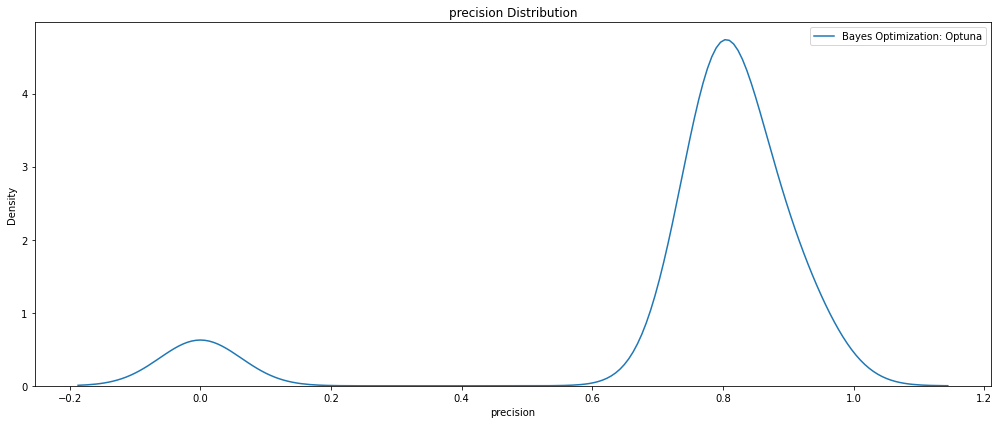

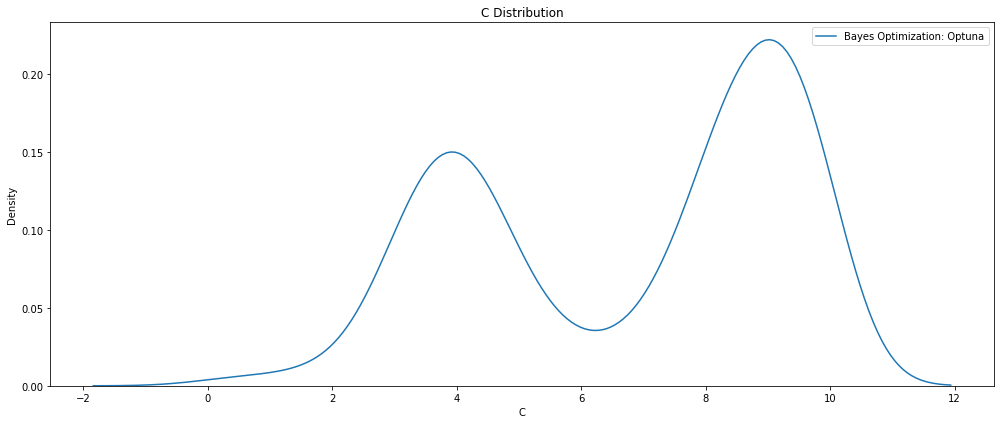

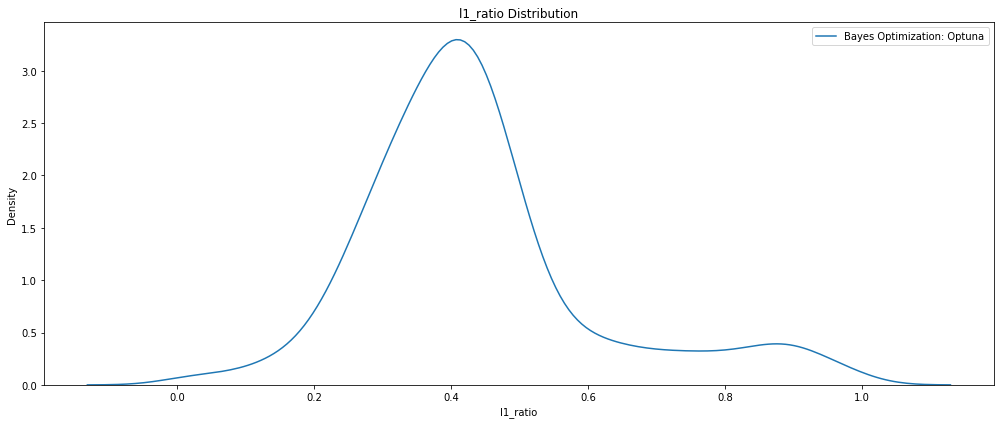

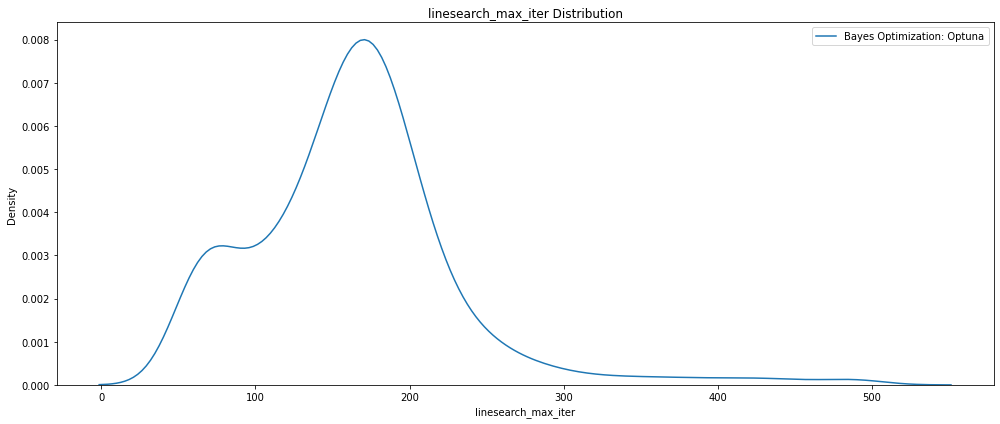

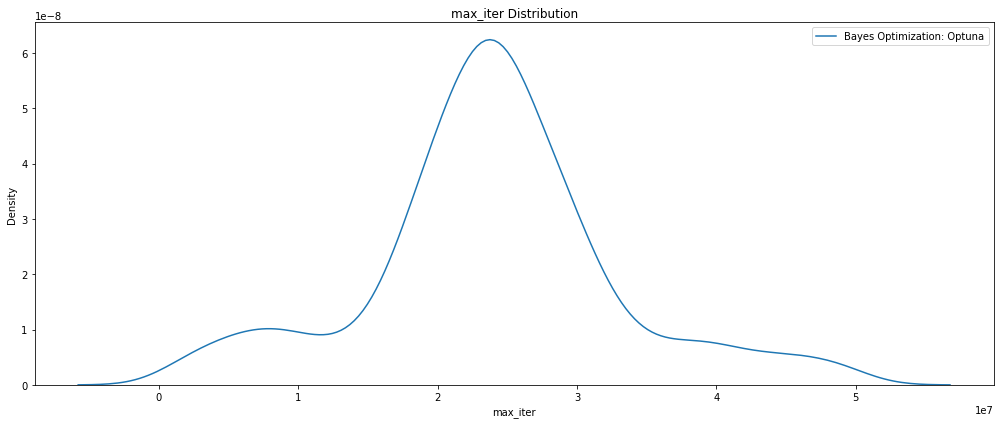

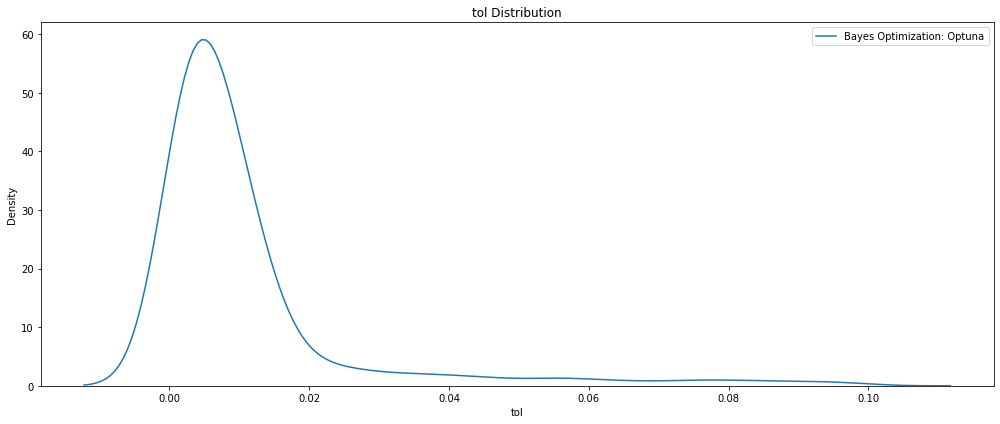

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','penalty', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Logistic_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'C': 8.3,
 'l1_ratio': 0.49228851016431374,
 'linesearch_max_iter': 150,
 'max_iter': 29524655,
 'penalty': 'l1',
 'tol': 0.0094172045062282}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = LogisticRegression(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Logistic_Optuna_SMOTE_trials1000_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Logistic_Optuna_SMOTE_trials1000_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Logistic HPO SMOTE 1000 trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for Logistic HPO SMOTE 1000 trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    377848
           1       0.80      0.77      0.78     54625

    accuracy                           0.95    432473
   macro avg       0.88      0.87      0.88    432473
weighted avg       0.95      0.95      0.95    432473



Confusion matrix:
[[367151  10697]
 [ 12564  42061]]


Accuracy score : 0.946
Precision score : 0.797
Recall score : 0.770
F1 score : 0.783


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 1000 GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                     y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 1000 GPU Precision trials optimization scores 0.87084 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     883
precision                                0.956906
datetime_start         2022-07-03 03:03:46.774609
datetime_complete      2022-07-03 03:03:50.169967
duration                   0 days 00:00:03.395358
C                                             8.3
l1_ratio                                 0.492289
linesearch_max_iter                           150
max_iter                                 29524655
penalty                                        l1
tol                                      0.009417
state                                    COMPLETE
Name: 883, dtype: object
